In [12]:
from utils import * 
from algorithms import *
from agents import *

# parameters
disclosure = ['step']; numStates = 6; depth = 1
#disclosure = ['step', 'currentBid', 'currentAsk', 'buy', 'sell', 'price', 'sale']; numStates = 12; depth = 1;
#disclosure = ['step', 'currentBid', 'currentAsk', 'buy', 'sell', 'price', 'sale', 'currentBidIdx_0', 'currentBidIdx_1','currentBidIdx_2','currentBidIdx_3','currentAskIdx_0', 'currentAskIdx_1', 'currentAskIdx_2','currentAskIdx_3']; numStates = 20; depth = 1; 
#depth = 1; numStates = 28; disclosure = ['step', 'currentBid', 'currentAsk', 'buy', 'sell', 'price', 'sale','currentBidIdx_0', 'currentBidIdx_1', 'currentBidIdx_2', 'currentBidIdx_3','currentAskIdx_0', 'currentAskIdx_1', 'currentAskIdx_2', 'currentAskIdx_3','bids_0', 'bids_1', 'bids_2', 'bids_3', 'asks_0', 'asks_1', 'asks_2', 'asks_3']

# game setup
numRounds, numPeriods, numSteps, numBuyers, numSellers, numTokens, gameTypes, seed = 3000, 1, 16, 4, 4, 4, '1111', None
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]
episodeLength = 16; numTrajectories = 1; gamma=0.99; std_init = 0.2; std_decay = 0.995; std_min = 0.05; lr = 0.0003; k = -0.15; p = 0.3
buyers = [
    Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
         ]
sellers = [ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0)
          ]

# logging
log = Log(gameData, disclosure,depth)
printInterval1, printInterval2, cnt, bprofits_history, sprofits_history, bidder_bids, bidder_profits = 100, 300, 0, [], [], [], []

# training loop
for rnd in range(numRounds):
    startRounds(gameData, log, buyers, sellers, rnd)
    bprofits, sprofits = 0.0, 0.0
    for period in range(numPeriods):
        startPeriods(buyers, sellers)
        for step in range(numSteps):
            startSteps(buyers, sellers)

            for i in range(numBuyers):
                buyers[i].state = log.generateState(buyers[i], cnt, numStates)

            bids, asks = collectOffers(buyers, sellers)
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
            bprofit, sprofit = 0, 0
            if price > 0:
                buyers[currentBidIdx].transact(price)
                sellers[currentAskIdx].transact(price)
                bprofit = buyers[currentBidIdx].stepProfits
                sprofit = sellers[currentAskIdx].stepProfits
            log.addStep([rnd, period, step, currentBid, currentAsk,  buy, sell, price, price>0,
                         currentBidIdx==0, currentBidIdx==1, currentBidIdx==2, currentBidIdx==3, 
                         currentAskIdx==0, currentAskIdx==1, currentAskIdx==2, currentAskIdx==3, 
                         bids[0], bids[1], bids[2], bids[3], 
                         asks[0], asks[1], asks[2], asks[3], 
                         bprofit, sprofit])
            observe(buyers, sellers, log.disclose())
            endSteps(buyers, sellers)
            
            for i in range(numBuyers):
                buyers[i].newState = log.generateState(buyers[i], cnt, numStates)
                
            if step == numSteps - 1:
                for i in range(numBuyers):
                    buyers[i].done = True                  
            else:
                for i in range(numBuyers):
                    buyers[i].done = False

            agentsObserve(buyers, sellers)
            agentsTrain(buyers, sellers)
            cnt+=1
        endPeriods(buyers, sellers)
    endRounds(buyers, sellers)

# terminate
log.findCurrentTraders()
#log.stepData.to_csv(f'data/log_{len(disclosure)}_{depth}_{t}.csv')
#log.roundData.to_csv(f'data/round_{len(disclosure)}_{depth}_{t}.csv')

KeyboardInterrupt: 

In [ ]:
log.findCurrentTraders()


In [ ]:
log.stepData[log.stepData.currentBidIdx_0==1].groupby(['rnd']).sum().bprofit.rolling(window=100).mean().plot()

<Axes: xlabel='rnd'>

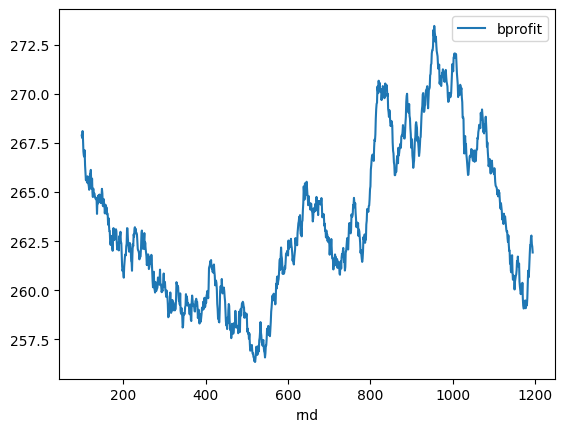

In [13]:
log.stepData[['bprofit', 'rnd']].groupby('rnd').sum().rolling(window=100).mean().plot()